In [9]:
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pipeline import *
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def condition_1(cen_off, cen_off_std, z, z0=0.228, thre=1):
    return (cen_off>thre) & (cen_off>3*cen_off_std) & (abs(z-z0)<0.015) #& (z>0.22)

def condition_2(cen_off, cen_off_std, z, z0=0.228, thre=1):
    return (cen_off>thre+3*cen_off_std) & (abs(z-z0)<0.015)

In [ ]:
datacube_C = Read_Datacube('./output/A2390C/A2390C_cube_lpf.fits', 
                           name='A2390C', z0=0.228, mode="MMA",
                           table='./output/A2390C/A2390C_MMA_lpf.dat')

datacube_E = Read_Datacube('./output/A2390E/A2390E_cube_lpf.fits',
                           name='A2390E', z0=0.228, mode="MMA",
                           table='./output/A2390E/A2390E_MMA_lpf.dat')

datacube_W = Read_Datacube('./output/A2390W/A2390W_cube_lpf.fits', 
                           name='A2390W', z0=0.228, mode="MMA",
                           table='./output/A2390W/A2390W_MMA_lpf.dat')
wcs_C = datacube_C.get_wcs()
wcs_E = datacube_E.get_wcs()
wcs_W = datacube_W.get_wcs()

In [225]:
subtract = True
sum_type = 'weighted'
sn = 2.0

tab_A2390C = Table.read('./output/A2390C/centroid_analysis_A2390C_%s_sn%.1f_lpf.txt'%(sum_type, sn), format='ascii')
tab_A2390E = Table.read('./output/A2390E/centroid_analysis_A2390E_%s_sn%.1f_lpf.txt'%(sum_type, sn), format='ascii')
tab_A2390W = Table.read('./output/A2390W/centroid_analysis_A2390W_%s_sn%.1f_lpf.txt'%(sum_type, sn), format='ascii')
tab_A2390C[:10]

ID,ra,dec,z,X,Y,SN_Ha,SN_OIII,SN_OII,diff_angle_ISO-D,cen_offset_ISO-D,diff_angle_std_ISO-D,cen_offset_std_ISO-D,pa_ISO-D,diff_angle_ISO-Dm,cen_offset_ISO-Dm,diff_angle_std_ISO-Dm,cen_offset_std_ISO-Dm,pa_ISO-Dm,clus_cen_angle,dist_clus_cen
str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1C,328.4375,17.5798,0.2502,621.76,15.07,30.855,29.096,32.712,93.561,1.199,17.025,0.324,250.782,90.633,1.603,6.163,0.172,253.71,344.344,1342.162
6C,328.3969,17.5803,0.2472,1056.61,27.87,9.298,10.252,9.412,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
106C,328.4743,17.5928,0.2322,223.86,153.6,6.459,6.056,6.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
125C,328.4377,17.5953,0.2424,620.0,193.88,8.025,8.813,8.104,49.786,0.444,23.864,0.221,292.173,nan,nan,nan,nan,nan,nan,nan
213C,328.3937,17.607,0.25,1087.34,333.52,49.56,18.656,19.66,55.405,0.374,2.255,0.016,310.599,34.901,0.498,14.325,0.125,331.104,6.004,994.693
221C,328.4311,17.6077,0.2281,691.19,336.49,6.096,4.795,5.916,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
235C,328.4138,17.6097,0.2309,874.57,361.27,26.386,16.515,22.849,105.075,1.404,0.9,0.022,248.401,112.871,1.63,7.623,0.217,240.604,353.475,965.381
245C,328.4885,17.6125,0.2253,69.84,375.32,16.52,13.342,16.389,104.203,0.94,2.974,0.037,211.491,107.053,0.608,24.156,0.256,208.641,315.694,1296.162
308C,328.3333,17.6169,0.2543,1729.09,448.52,8.315,7.286,9.159,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [226]:
# Match with each other
c_A2390C, c_A2390E, c_A2390W =  [SkyCoord(tab['ra'], tab['dec'], frame='icrs', unit="deg")
                                 for tab in [tab_A2390C, tab_A2390E, tab_A2390W]]

idx, d2d, d3d = c_A2390E.match_to_catalog_sky(c_A2390C)
match = d2d < 3*u.arcsec
tab_EC = tab_A2390E[match]
tab_CE = tab_A2390C[idx[match]]

idx, d2d, d3d = c_A2390W.match_to_catalog_sky(c_A2390C)
match = d2d < 3*u.arcsec
tab_WC = tab_A2390W[match]
tab_CW = tab_A2390C[idx[match]]

# Stack table
tab_E, tab_C, tab_W = tab_A2390E.copy(), tab_A2390C.copy(), tab_A2390W.copy()
tab_A2390 = vstack([tab_C, tab_E , tab_W], join_type='inner')

# Remove repeated source with lower SNR
good_E = tab_EC['SN_Ha']>tab_CE['SN_Ha']
id_rm_EC = tab_EC['ID'][~good_E].data
id_rm_CE = tab_CE['ID'][good_E].data

good_W = tab_WC['SN_Ha']>tab_CW['SN_Ha']
id_rm_WC = tab_WC['ID'][~good_W].data
id_rm_CW = tab_CW['ID'][good_W].data

for id_rm in np.concatenate([id_rm_EC, id_rm_WC, id_rm_CW, id_rm_CE]):
    tab_A2390.remove_row(np.where(tab_A2390['ID']==id_rm)[0][0])
    
candidate_path_OIII = os.path.join('./output/*/pic/candidate_MMA_lpf',"C/*#*.png")
dir_OIII = glob.glob(candidate_path_OIII)
f_OIII = np.array([re.compile(r'[CEW]#\d+').findall(el)[-1] for el in dir_OIII])
id_OIII = [re.compile(r'\d+').findall(f)[0]+f[0] for f in f_OIII]
id_non_clus = id_OIII + ['1687C', '1884C']
print(id_non_clus)

tab = tab_A2390.copy()

irow_non_clus = np.array([],dtype=int)
for id_non in id_non_clus:
    irow_non_clus = np.append(irow_non_clus, np.argwhere(tab['ID']==id_non))
tab.remove_rows(irow_non_clus)
tab.remove_row(np.argmin((tab['X']-980)**2 + (tab['Y']-1315)**2))

not_edge = (tab["X"]>=100) & (tab["X"]<=(2064-100)) & (tab["Y"]>=100) & (tab["Y"]<=(2048-100))
has_offset = tab['cen_offset_ISO-D'] > 3 * tab['cen_offset_std_ISO-D']
cond = not_edge & has_offset

tab = tab[cond]
print(len(tab))
tab

['6C', '125C', '439C', '500C', '704C', '738C', '830C', '870C', '953C', '1265C', '289E', '432E', '546E', '757E', '1279E', '1340E', '1420E', '774W', '997W', '1066W', '1687C', '1884C']
111


ID,ra,dec,z,X,Y,SN_Ha,SN_OIII,SN_OII,diff_angle_ISO-D,cen_offset_ISO-D,diff_angle_std_ISO-D,cen_offset_std_ISO-D,pa_ISO-D,diff_angle_ISO-Dm,cen_offset_ISO-Dm,diff_angle_std_ISO-Dm,cen_offset_std_ISO-Dm,pa_ISO-Dm,clus_cen_angle,dist_clus_cen
str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
213C,328.3937,17.607,0.25,1087.34,333.52,49.56,18.656,19.66,55.405,0.374,2.255,0.016,310.599,34.901,0.498,14.325,0.125,331.104,6.004,994.693
235C,328.4138,17.6097,0.2309,874.57,361.27,26.386,16.515,22.849,105.075,1.404,0.9,0.022,248.401,112.871,1.63,7.623,0.217,240.604,353.475,965.381
329C,328.455,17.6219,0.2263,435.68,491.41,18.445,7.252,8.074,46.926,2.946,1.358,0.041,279.389,39.114,1.64,3.914,0.112,287.202,326.315,988.158
350C,328.3927,17.6227,0.2245,1096.38,511.03999999999996,15.392,7.171,8.689,164.266,1.142,2.429,0.03,172.303,167.282,1.332,11.485,0.267,175.318,8.037,821.041
399C,328.3865,17.6287,0.2501,1161.87,578.63,50.622,11.901,13.45,172.235,0.838,0.37,0.005,201.442,156.812,1.07,8.288,0.155,216.865,13.677,767.828
418C,328.4255,17.6318,0.2502,749.11,607.85,24.369,22.592,21.334,118.256,0.427,6.363,0.044,100.006,126.483,0.505,33.746,0.297,108.232,341.75,749.351
452C,328.3117,17.6348,0.2263,1958.53,649.93,65.418,8.265,9.538,42.798,0.093,0.771,0.002,12.458,44.559,0.803,7.911,0.111,10.697,55.256,1190.417
459C,328.4796,17.6371,0.2295,169.01,657.09,25.94,16.707,20.64,162.114,0.748,3.65,0.037,146.717,133.063,1.579,11.341,0.313,175.769,308.831,1040.454
463C,328.3778,17.6359,0.2496,1252.76,659.94,26.507,19.896,20.904,8.09,0.262,3.007,0.012,30.487,109.642,0.107,109.145,0.205,132.039,22.397,719.648


In [222]:
import astropy.units as u
import astropy.constants as c

def g_c(C):
    return 1./(np.log(1+C)-C/(1+C))

def K(s,C=6):
    return g_c(C)*np.log(1+C*s)/s

def V_esc(R, R_vir=1.55*u.Mpc, M_vir=1e14*c.M_sun, C=6):
    s = R/R_vir
    v_esc = np.sqrt(2*c.G*M_vir*K(s,C)/R_vir).to(u.km/u.s)
    return v_esc

def Sigma_vir(R_vir, M_vir):
    return np.sqrt(c.G*M_vir/R_vir).to(u.km/u.s)

from astropy.cosmology import FlatLambdaCDM
h = 0.7
cosmo = FlatLambdaCDM(H0=100*h, Om0=0.3)
distance_cluster = cosmo.angular_diameter_distance(z=0.228)
print(distance_cluster)

len_1arc = distance_cluster*u.arcsec.to(u.rad)
len_pix = len_1arc * 0.322  #pixel length in Mpc
print("1kpc = %.3f pix"%(1/len_pix.to(u.kpc)).value)

v_vir = 1100 * u.km/u.s  #velocity_dispersion
R_vir = 1.51/h * u.Mpc
sigma_v = Sigma_vir(R_vir=R_vir, M_vir=2e15*c.M_sun)
print(R_vir, v_vir)

l_Rvir = (len_pix/R_vir).value # pixel length in Rvir 1 pix = l R_vir

rr = np.linspace(0.001,10,100) *u.Mpc
vv = V_esc(rr, R_vir=R_vir, M_vir=2e15*c.M_sun, C=4) # C from Allen2000

752.8932528699639 Mpc
1kpc = 0.851 pix
2.1571428571428575 Mpc 1100.0 km / s


In [196]:
def draw_phase_diagram(table, cond, centroid_type='ISO-D', add_text=True,
                       r1=1., v1=1., r2=2., v2 = 3., z0=0.228, threshould=1, ax=None):
    sigma = v_vir
    r_norm = np.array(table['dist_clus_cen']) * l_Rvir  # normed distance in R_vir
    v_norm = (abs(np.array(table['z'])-z0) * 3e5*u.km/u.s / sigma).value
    # normed vel in v_vir (sigma_vir)
    
    d_cen_v = table['cen_offset'+'_'+centroid_type]
    d_cen_std_v = table['cen_offset'+'_'+centroid_type]
    d_angle_v = table['diff_angle'+'_'+centroid_type]
    
    v_esc = lambda r: V_esc(r, R_vir=R_vir, M_vir=2e15*c.M_sun, C=4)
    vv = v_esc(r_norm*R_vir)
    
#     in_cluster = (((r_norm/r2)**2 + (v_norm/v2)**2) < 1.)  # circle
#     in_cluster = ((v_norm/v1) < 1.5*(r_norm/r1)**(-0.5))   # inv-square
    in_cluster = v_norm < (vv/sigma_v)   # escape vel (normed in 3D)

    cond1, cond2 = cond&(d_angle_v<=90)& in_cluster, cond&(d_angle_v>90)& in_cluster
    
    if ax is None:
        plt.figure(figsize=(9,8))
        ax = plt.subplot(111)
        
    plt.scatter(r_norm[~(cond1|cond2)& in_cluster], v_norm[~(cond1|cond2)& in_cluster], s=150, color="gray",
                edgecolor="none",alpha=0.8,zorder=3, label=None)
    plt.scatter(r_norm[cond1], v_norm[cond1], s=250, color="steelblue",
                edgecolor="none",alpha=0.8,zorder=3,
                label="$\Delta\,d>%.1f$ pix , $\\theta<90^\circ$"%threshould)
    plt.scatter(r_norm[cond2], v_norm[cond2], s=250, color="firebrick",
                edgecolor="none",alpha=0.8,zorder=3,
                label="$\Delta\,d>%.1f$ pix , $\\theta>90^\circ$"%threshould)
    
    virial = ((r_norm/r1)**2 + (v_norm/v1)**2) <= 1.
    non_virial = (~virial) & in_cluster
    inner = ((r_norm/r1)**2 <= 1.) & in_cluster
    outer = ((r_norm/r1)**2 > 1.) &  in_cluster   
    
    condA = non_virial & (r_norm<=1) 
    condB = virial  
    condC = non_virial & (r_norm>1)   

    condA1, condB1, condC1 = condA&cond1, condB&cond1, condC&cond1  
    condA2, condB2, condC2 = condA&cond2, condB&cond2, condC&cond2 
                  
    plt.text(0.05, 0.84,r"$\bf A$",color="k",va="center",fontsize=25,transform=ax.transAxes)
    plt.text(0.05, 0.22,r"$\bf B$",color="k",va="center",fontsize=25,transform=ax.transAxes)
    plt.text(0.85, 0.1,r"$\bf C$",color="k",va="center",fontsize=25,transform=ax.transAxes)
   
    ft = 22
    plt.text(0.76, 0.94,"A :",color="k",va="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.76, 0.86,"B :",color="k",va="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.76, 0.78,"C :",color="k",va="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.84, 0.94,"%d"%(np.sum(condA1)),color="steelblue",va="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.84, 0.86,"%d"%(np.sum(condB1)),color="steelblue",va="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.84, 0.78,"%d"%(np.sum(condC1)),color="steelblue",va="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.9, 0.94,"%d"%(np.sum(condA2)),color="firebrick",va="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.9, 0.86,"%d"%(np.sum(condB2)),color="firebrick",va="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.9, 0.78,"%d"%(np.sum(condC2)),color="firebrick",va="center",fontsize=ft,transform=ax.transAxes)

    from matplotlib.patches import Ellipse
    ellipse1 = Ellipse(xy=(0,0), width=2*r1, height=2*v1, 
                      edgecolor='orange', fc='orange', lw=5, alpha=0.4,zorder=2)
    ax.add_patch(ellipse1)

    df = pd.read_csv("/home/qliu/Downloads/Jaffe2018a.csv",header=None)  #Jaffe2018
    r_Jafa, v_Jafa = df.iloc[:,0], df.iloc[:,1]
    plt.plot(np.unique(r_Jafa), np.poly1d(np.polyfit(r_Jafa, v_Jafa, 1))(np.unique(r_Jafa)),
             color="y", lw=5,ls="-",alpha=0.5,label="High M Galaxy")

    df = pd.read_csv("/home/qliu/Downloads/Jaffe2018b.csv",header=None)  #Jaffe2018
    r_Jafa, v_Jafa = df.iloc[:,0], df.iloc[:,1]
    plt.plot(np.unique(r_Jafa), np.poly1d(np.polyfit(r_Jafa, v_Jafa, 1))(np.unique(r_Jafa)),
             color="m", lw=5,ls="-",alpha=0.5,label="Low M Galaxy")

    xx = np.linspace(0.01,2.2*R_vir.value) * u.Mpc
    plt.fill_between(xx/R_vir, y1=v_esc(xx)/sigma_v,y2=0,color='seagreen',alpha=0.2,zorder=1)
    
    plt.vlines(1, ymin=0.01, ymax=v_esc(R_vir)/sigma_v,color="k",linestyle=":", alpha=0.7, lw=4)
    
    if add_text:
        for (r, v, ID) in zip(r_norm[in_cluster], v_norm[in_cluster], table["ID"][in_cluster]):
            if r>0: 
                plt.text(r, v, ID, fontsize=8)

    plt.xlim(-0.005, r2+0.05), plt.ylim(-0.005, v2+0.1)
    plt.xticks(fontsize=14), plt.yticks(fontsize=14)
    plt.xlabel("r / R$_{200}$",fontsize=18)
    plt.ylabel("|v$_{los}$ - v$_0$| / $\sigma_{vir}$",fontsize=18)
    plt.legend(loc=9,fontsize=14)
    
    plt.tight_layout()
    return in_cluster, non_virial, inner

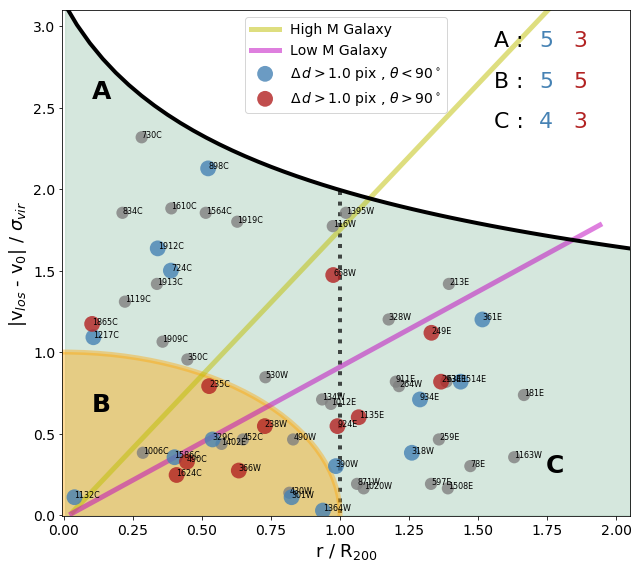

In [223]:
# SN 2.0 mean
thre = 1
cond_iso = condition_1(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=thre) # 1kpc

in_cluster, non_virial, inner = draw_phase_diagram(tab, cond_iso, centroid_type='ISO-D', threshould=thre)
plt.plot(rr/R_vir, vv/sigma_v, color="k",lw=4,ls="-")

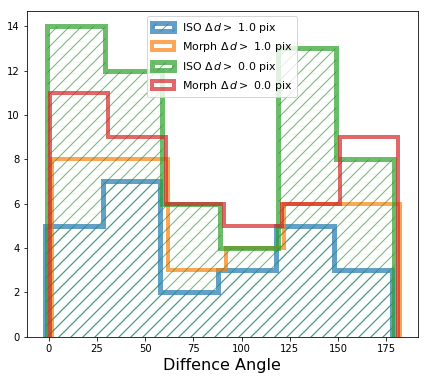

In [224]:
plt.figure(figsize=(7,6))
thre = 1
cond_iso = condition_1(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=thre) # 1 kpc
cond_mor = condition_1(tab['cen_offset_ISO-Dm'], tab['cen_offset_std_ISO-Dm'], tab['z'], thre=thre) # 1 kpc
d_angle_iso = tab['diff_angle_ISO-D'][cond_iso & in_cluster]
d_angle_mor = tab['diff_angle_ISO-Dm'][cond_mor & in_cluster]

plt.hist(d_angle_iso-2, histtype="step", bins=np.linspace(0,180,7)-2, hatch="//", lw=5, alpha=0.7,
        label='ISO $\Delta\,d>$ %.1f pix'%thre, zorder=2)
plt.hist(d_angle_mor+2, histtype="step", bins=np.linspace(0,180,7)+2, hatch="", lw=4, alpha=0.7,
        label='Morph $\Delta\,d>$ %.1f pix'%thre, zorder=2)

thre = 0.
cond_iso = condition_2(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=thre) # 1 kpc
cond_mor = condition_2(tab['cen_offset_ISO-Dm'], tab['cen_offset_std_ISO-Dm'], tab['z'], thre=thre) # 1 kpc
d_angle_iso = tab['diff_angle_ISO-D'][cond_iso & in_cluster]
d_angle_mor = tab['diff_angle_ISO-Dm'][cond_mor & in_cluster]

plt.hist(d_angle_iso-1, histtype="step", bins=np.linspace(0,180,7)-1, hatch="//", lw=5, alpha=0.7,
        label='ISO $\Delta\,d>$ %.1f pix'%thre, zorder=2)
plt.hist(d_angle_mor+1, histtype="step", bins=np.linspace(0,180,7)+1, hatch="", lw=4, alpha=0.7,
        label='Morph $\Delta\,d>$ %.1f pix'%thre, zorder=2)

plt.xlabel('Diffence Angle', fontsize=16)
plt.legend(loc=9,fontsize=11)

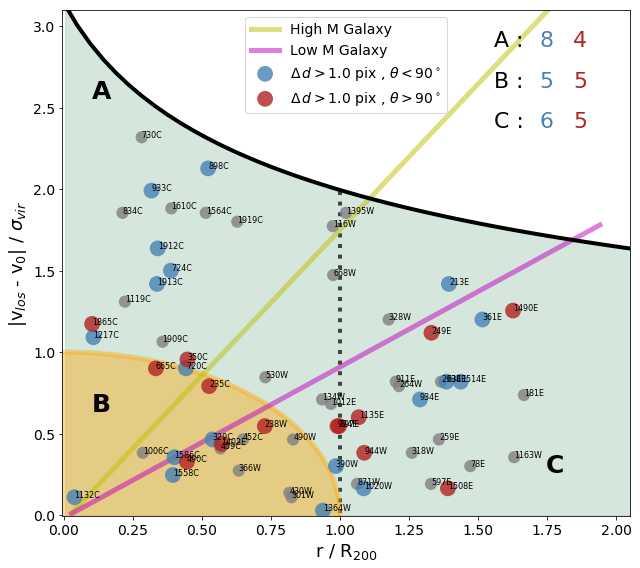

In [204]:
# SN 2.0 weighted
thre = 1
cond_iso = condition_1(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=thre) # 1kpc

in_cluster, non_virial, inner = draw_phase_diagram(tab, cond_iso, centroid_type='ISO-D', threshould=thre)
plt.plot(rr/R_vir, vv/sigma_v, color="k",lw=4,ls="-")

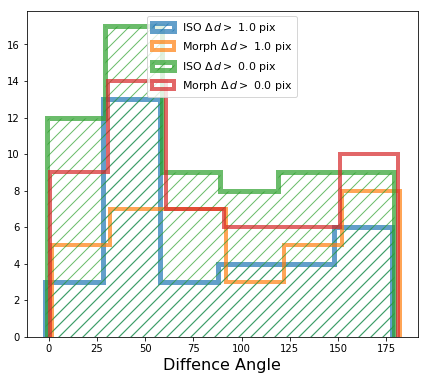

In [206]:
plt.figure(figsize=(7,6))
thre = 1
cond_iso = condition_1(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=thre) # 1 kpc
cond_mor = condition_1(tab['cen_offset_ISO-Dm'], tab['cen_offset_std_ISO-Dm'], tab['z'], thre=thre) # 1 kpc
d_angle_iso = tab['diff_angle_ISO-D'][cond_iso & in_cluster]
d_angle_mor = tab['diff_angle_ISO-Dm'][cond_mor & in_cluster]

plt.hist(d_angle_iso-2, histtype="step", bins=np.linspace(0,180,7)-2, hatch="//", lw=5, alpha=0.7,
        label='ISO $\Delta\,d>$ %.1f pix'%thre, zorder=2)
plt.hist(d_angle_mor+2, histtype="step", bins=np.linspace(0,180,7)+2, hatch="", lw=4, alpha=0.7,
        label='Morph $\Delta\,d>$ %.1f pix'%thre, zorder=2)

thre = 0.
cond_iso = condition_2(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=thre) # 1 kpc
cond_mor = condition_2(tab['cen_offset_ISO-Dm'], tab['cen_offset_std_ISO-Dm'], tab['z'], thre=thre) # 1 kpc
d_angle_iso = tab['diff_angle_ISO-D'][cond_iso & in_cluster]
d_angle_mor = tab['diff_angle_ISO-Dm'][cond_mor & in_cluster]

plt.hist(d_angle_iso-1, histtype="step", bins=np.linspace(0,180,7)-1, hatch="//", lw=5, alpha=0.7,
        label='ISO $\Delta\,d>$ %.1f pix'%thre, zorder=2)
plt.hist(d_angle_mor+1, histtype="step", bins=np.linspace(0,180,7)+1, hatch="", lw=4, alpha=0.7,
        label='Morph $\Delta\,d>$ %.1f pix'%thre, zorder=2)

plt.xlabel('Diffence Angle', fontsize=16)
plt.legend(loc=9,fontsize=11)

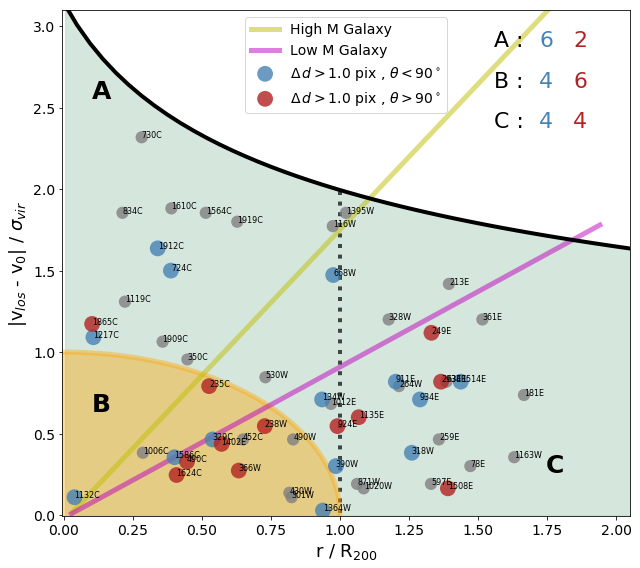

In [218]:
# SN 2.0 mean LPF
thre = 1
cond_iso = condition_1(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=thre) # 1kpc

in_cluster, non_virial, inner = draw_phase_diagram(tab, cond_iso, centroid_type='ISO-D', threshould=thre)
plt.plot(rr/R_vir, vv/sigma_v, color="k",lw=4,ls="-")

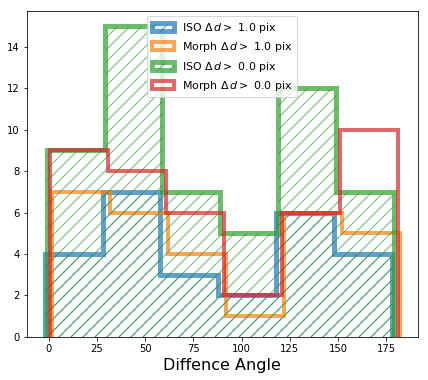

In [219]:
plt.figure(figsize=(7,6))
thre = 1
cond_iso = condition_1(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=thre) # 1 kpc
cond_mor = condition_1(tab['cen_offset_ISO-Dm'], tab['cen_offset_std_ISO-Dm'], tab['z'], thre=thre) # 1 kpc
d_angle_iso = tab['diff_angle_ISO-D'][cond_iso & in_cluster]
d_angle_mor = tab['diff_angle_ISO-Dm'][cond_mor & in_cluster]

plt.hist(d_angle_iso-2, histtype="step", bins=np.linspace(0,180,7)-2, hatch="//", lw=5, alpha=0.7,
        label='ISO $\Delta\,d>$ %.1f pix'%thre, zorder=2)
plt.hist(d_angle_mor+2, histtype="step", bins=np.linspace(0,180,7)+2, hatch="", lw=4, alpha=0.7,
        label='Morph $\Delta\,d>$ %.1f pix'%thre, zorder=2)

thre = 0.
cond_iso = condition_2(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=thre) # 1 kpc
cond_mor = condition_2(tab['cen_offset_ISO-Dm'], tab['cen_offset_std_ISO-Dm'], tab['z'], thre=thre) # 1 kpc
d_angle_iso = tab['diff_angle_ISO-D'][cond_iso & in_cluster]
d_angle_mor = tab['diff_angle_ISO-Dm'][cond_mor & in_cluster]

plt.hist(d_angle_iso-1, histtype="step", bins=np.linspace(0,180,7)-1, hatch="//", lw=5, alpha=0.7,
        label='ISO $\Delta\,d>$ %.1f pix'%thre, zorder=2)
plt.hist(d_angle_mor+1, histtype="step", bins=np.linspace(0,180,7)+1, hatch="", lw=4, alpha=0.7,
        label='Morph $\Delta\,d>$ %.1f pix'%thre, zorder=2)

plt.xlabel('Diffence Angle', fontsize=16)
plt.legend(loc=9,fontsize=11)

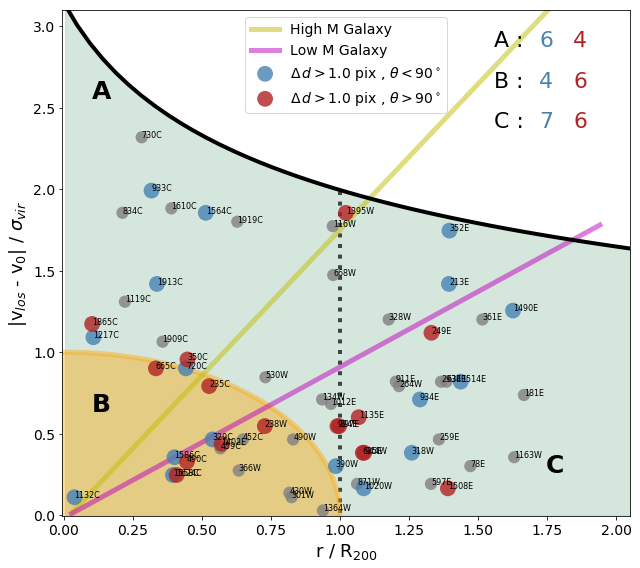

In [228]:
# SN 2.0 weighted LPF
thre = 1
cond_iso = condition_1(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=thre) # 1kpc

in_cluster, non_virial, inner = draw_phase_diagram(tab, cond_iso, centroid_type='ISO-D', threshould=thre)
plt.plot(rr/R_vir, vv/sigma_v, color="k",lw=4,ls="-")

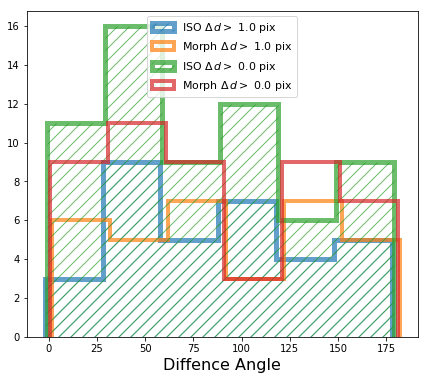

In [230]:
plt.figure(figsize=(7,6))
thre = 1
cond_iso = condition_1(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=thre) # 1 kpc
cond_mor = condition_1(tab['cen_offset_ISO-Dm'], tab['cen_offset_std_ISO-Dm'], tab['z'], thre=thre) # 1 kpc
d_angle_iso = tab['diff_angle_ISO-D'][cond_iso & in_cluster]
d_angle_mor = tab['diff_angle_ISO-Dm'][cond_mor & in_cluster]

plt.hist(d_angle_iso-2, histtype="step", bins=np.linspace(0,180,7)-2, hatch="//", lw=5, alpha=0.7,
        label='ISO $\Delta\,d>$ %.1f pix'%thre, zorder=2)
plt.hist(d_angle_mor+2, histtype="step", bins=np.linspace(0,180,7)+2, hatch="", lw=4, alpha=0.7,
        label='Morph $\Delta\,d>$ %.1f pix'%thre, zorder=2)

thre = 0.
cond_iso = condition_2(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=thre) # 1 kpc
cond_mor = condition_2(tab['cen_offset_ISO-Dm'], tab['cen_offset_std_ISO-Dm'], tab['z'], thre=thre) # 1 kpc
d_angle_iso = tab['diff_angle_ISO-D'][cond_iso & in_cluster]
d_angle_mor = tab['diff_angle_ISO-Dm'][cond_mor & in_cluster]

plt.hist(d_angle_iso-1, histtype="step", bins=np.linspace(0,180,7)-1, hatch="//", lw=5, alpha=0.7,
        label='ISO $\Delta\,d>$ %.1f pix'%thre, zorder=2)
plt.hist(d_angle_mor+1, histtype="step", bins=np.linspace(0,180,7)+1, hatch="", lw=4, alpha=0.7,
        label='Morph $\Delta\,d>$ %.1f pix'%thre, zorder=2)

plt.xlabel('Diffence Angle', fontsize=16)
plt.legend(loc=9,fontsize=11)